# TMA4320: Biofysikkprosjekt
Av: Ingrid M. Løvold, Oskar Farbrot og Cecilia M. B. Eide

## Introduksjon
I dette prosjektet har vi benyttet Monte Carlo-metode for å simulere polymerfolding. Polymerer kjemiske forbindelser som er bygd opp av store kjedeformede molekyler man kaller monomerer. Vi har skrevet kode i phyton som plasserer monomerer på en tilfeldig, men "lovlig" måte i et koordinatsystem. Kjeden av monomerer skal representere et polymer. DNA, RNA, og proteiner er naturlige polymerer, altså ved å forstå mere om polymerer kan vi også lære mer om grunnlaget til levende organismer.

Begynner med å importere nødvendige biblioteker.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

For å representere en polymer numerisk bruker vi et array av posisjonskoordinatene til hvert monomer. Det er et N x 2 array, der N er antall monomerer, og vi får N posisjonsvektorer på formen [x, y]. Indeksen i arrayet viser gjennomgående til et spesifikt monomers posisjon. Vi slipper da å lagre alle de tomme posisjonene og får mer effektiv kode.

I flere av simulisasjonene tar vi utgangspunkt i en rett polymer og har derfor definert funksjonen makeStraightPolymer(N) som vist i kodeblokken under. Denne tar inn lengden på polymeren, N, og gir ut en horisontal polymer midt i et koordinatsystem med størrelse N x N. Er N et partall vil den legge seg på den øverste av de to midterste radene, men dette påvirker ikke koden ytterligere.

In [4]:
def makeStraightPolymer(N): #Make a straight polymer with length N
    y = int(N/2) + 1 #arrange at 1/2 of length in y-direction (middle, depending on odd/even N)
    koord = np.zeros((N, 2), dtype=int)
    
    for i in range(N):
        koord[i] = [i+1, y]
    
    return koord #N x 2 matrix containing coordinates for monomer 1-N position, indexed 0 - (N-1)

For å simulere et polymer som foldes bruker vi rotasjoner. Disse rotasjonene skjer i et plan. En rotasjon tilsvarer å knekke polymeren 90 grader, enten med- eller mot klokken. Funksjonen rotatePolymer(polymer, koord, rot) itererer gjennom monomerene i polymeret og roterer den korteste delen av polymeren, i tilfeldig retning, om den indekserte monomeren. 

En eventuell energiendring for polymeren skyldes svake vekselvirkninger mellom monomerer som ikke allerede er bundet 
av kovalente bindinger. En rotasjon rundt et endepunkt på polymeren vil ikke gi en energiendring, da ingen monomerer 
endrer posisjoner relativt til hverandre og derfor ikke vil oppleve noen endrede vekselvirkninger.

Polymeren som system ønsker å minimere energien sin, og senere i oppgaven vil vi se at den som hovedregel kun endrer 
tilstand dersom den totale energiendringen er mindre enn null. Dersom en rotasjon om et endepunkt likevel inntreffer 
grunnet termiske fluktasjoner som tillater ugunstige endringer, kan vi dessuten også se at dette ikke utgjør en reell 
endring for systemet vi simulerer. Vår løsning av oppgaven velger alltid å rotere den korteste enden fra rotasjonsmonomeren, 
som for et endepunkt ikke vil inneholde noen monomerer i det hele tatt og derfor åpenbart ikke endre polymeren. Skulle vi 
likevel valgt å rotere den lengste enden, vil heller ikke monomerenes posisjoner endres relativt til hverandre. Å tillate 
en slik rotasjon i simuleringen vil være det samme som å endre polymerens orientering i koordinatsystemet, og utgjør ikke 
en reell forskjell for polymeren. Uansett metode vil rotasjon om endepunkt være et urelevant tilfelle, og vi har derfor 
vurdert at det ikke er hensiktsmessig å inkludere koordinater for endemonomerer i utvalget av rotasjonsmonomerer.

(Rotasjonsfunksjonen vil ikke returnere en polymer som ikke er sammenhengende og første if setning er unødvendig! Ta med i diskusjon for raskere kode.)

In [5]:
def rotatePolymer(polymer, koord, rot): 
    polymer = np.copy(polymer)
    for i in range(len(polymer)): #Kan ta (1, len(polymer) - 1) for raskere kode, siden vi ikke tar hensyn til rot om endemonomerer
        if polymer[i][0] == koord[0] and polymer[i][1] == koord[1]:
            rot_om = i
        
    if rot_om > len(polymer)/2: #Rotates monomers with index higher than the rotation-coordinate
        for i in range(rot_om + 1, len(polymer)):
            avstandsvektor = polymer[i] - polymer[rot_om]
            
            if rot == True: #Clockwise
                avstandsvektor[0], avstandsvektor[1] = avstandsvektor[1], -avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
            
            else: #Counter-clockwise
                avstandsvektor[0], avstandsvektor[1] = -avstandsvektor[1], avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
    
    else: #Rotates monomers with index lower than the rotation-coordinate
        for i in range(rot_om):
            avstandsvektor = polymer[rot_om] - polymer[i] 
            if rot == True: #Clockwise
                avstandsvektor[0], avstandsvektor[1] = avstandsvektor[1], avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
            
            else: #Counter-clockwise
                avstandsvektor[0], avstandsvektor[1] = -avstandsvektor[1], -avstandsvektor[0]
                polymer[i] = polymer[rot_om] + avstandsvektor
            
    return polymer

Et polymer skal være sammenhengende og det skal ikke foldes slik at monomerer havner i samme koordinater. Rotasjonsfunksjonen kontrollerer ikke at disse reglend overholdes, derfor har vi også laget en funksjonen polymerIntact(polymer, N) som returnerer false om to monomerer ligger i samme koordinat, eller om monomeren indeksert med [i] ikke ligger inntil monomerene indeksert med [i+1] og [i-1]. I henhold til oppgave 1 i prosjektbeskrivelsen.

In [6]:
def polymerIntact(polymer, N): #Error.. #Checking predefined rules for intact polymer (intact -> True)
    #Checking if polymer contains N monomers
    if len(polymer) != N:
        return False
    
    #Checking if any monomers are overlapping (two or more at same coord.)
    unique_positions = set()
    for monomer in polymer:
        # Convert numpy array to tuple for set insertion
        pos = tuple(monomer)
        unique_positions.add(pos)

    if len(unique_positions) != N:
        return False
    
    #Verifying that each monomer is neighbouring the previos one. (this should always be the case with the way our polymers are made and handeled throughut the project?)
    for i in range(len(polymer) - 1):
        dx = abs(polymer[i][0] - polymer[i + 1][0])
        dy = abs(polymer[i][1] - polymer[i + 1][1])
        if not ((dx == 1 and dy == 0) or (dx == 0 and dy == 1)):
            return False
    
    return True

Nå ønsker vi å folde den rette polymeren vi har konstruert i funksjonen makeStraightPolymer. Funksjonen N_simuleringer forsøker å folde monomeren et gitt antall ganger (N_s) og returnerer en polymer med de vellykkede rotasjonene. 

In [7]:
def N_simuleringer(N, N_s): #simulates N_s rotation attempts of a polymer of length N
    counter = 0
    polymer = makeStraightPolymer(N)
    
    for i in range(N_s):
        koord = polymer[np.random.randint(1, N-1)] #Excludes end-monomers
        rot = np.random.randint(0, 2)
        twisted_polymer = rotatePolymer(polymer, koord, rot)
        
        if polymerIntact(twisted_polymer, N) == True:
            counter += 1
            polymer = twisted_polymer
            
    return polymer, counter

For å illustrere et polymeren bruker vi funksjonen illustratePolymer(polymer) som vist i kodeblokken under.

In [8]:
def illustratePolymer(polymer, name):
    
    M = len(polymer) + 2 #Legger til en på hver side for finere plot, derfor + 2
    
    x = np.arange(0, M, 1)
    y = np.arange(0, M, 1)
    
    insertPolymer = np.zeros((M, M))
        
    for i in range(len(polymer)):  
        insertPolymer[int(polymer[i][1])][int(polymer[i][0])] = i+1 #each monomer placed in grid and assigned increasing int values thorughout the chain 
        plt.text(int(polymer[i][0]), int(polymer[i][1]), str(i+1), ha='center', va='center') #print assigned number
    
    plt.title(name)
    plt.pcolormesh(x, y, insertPolymer) #colour distinguish
    plt.show()

Vi kjører nå to simulasjoner av en rett polymer med 15 monomerer som foldes. I den ene forsøkes den å foldes 4 ganger og i den andre 1000. Deretter illustreres resultatet.

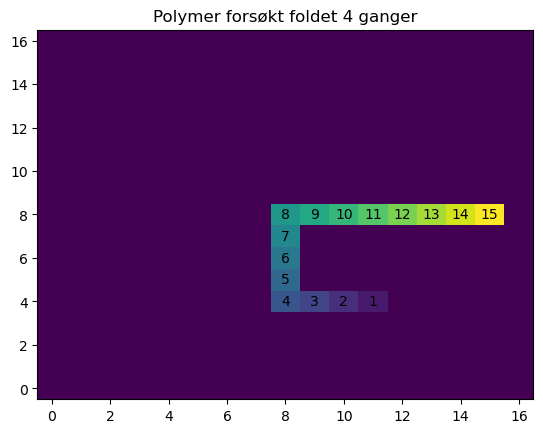

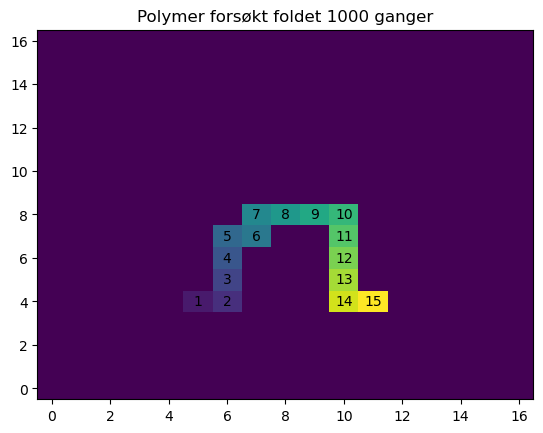

In [9]:
a = N_simuleringer(15, 4)[0]
b = N_simuleringer(15, 1000)[0]

illustratePolymer(a, 'Polymer forsøkt foldet 4 ganger')
illustratePolymer(b, 'Polymer forsøkt foldet 1000 ganger')

Mer legges inn bla bla bla

Polymeren som forsøkes rotert 4 ganger får en energi som er høyere (nærmere null) enn polymeren som forsøkes tvistet 1000 ganger. Energien til polymeret avhenger av hvor mange vekselvirkende monomerer man har. Det vil danne seg flere vekselvirkende monomerer hvis man roterer mange ganger. Det er naturlig at man med med mange forsøk på rotasjon også får flere rorasjoner som er vellykket. 


Vi har til nå i prosjektet ikke tatt hensyn til vekselvirkninger mellom monomerene i polymerene, som gir opphav til en energiendring ved rotasjoner. For å få dette inn i modellen lager vi en vekselsvirkningsmatrise V, i funksjonen make_V(polymer, v_Energy), som angir vekselsvirkning mellom to monomerer. Vi antar at monomerer kun vekselvirker hvis de er nærmeste naboer og at de ikke opplever vekselvirkning fra monomerene ved siden av seg i rekken, altså ikke mellom monomerer som har kovalent binding, eller fra seg selv. Derfor må elementene i diagobalen, overdiagonalen og underdiagonalen. Videre må matrisen være symetrisk siden vekselvirkningen fra monomer m på monomer n, må være like vekselvirkningen fra monomer n på monomer m. Når vi lager V i denne funksjonen antar vi at alle elementene som ikke er lik null har samme verdi, men dette er ikke egentlig noe krav. Vi vil se mer på dette senere i oppgaven

In [10]:
def make_V(polymer, v_Energy):
    N  = len(polymer)
    V = np.full((N, N), v_Energy)
    for i in range(N):
        for j in range(N):
            if i == j:
                V[i][j]=0
            elif i == j+1:
                V[i][j]=0
                V[j][i]=0
    return V

For å finne energien til et polymer må vi summere over alle vekselsvirkningene. Dette gjør vi med å gange V-matrisen med operatoren b, som er 1 hvis de to monomerene vekselvirker og 0 hvis de ikke vekselvirker. Man finner da energien ved å dele summen av elementene i den nye matrisen delt på 2, slik at vekselvirkning mellom to monomerer ikke teller to ganger.

In [11]:
def calculate_energy(polymer, V):
    polymer = np.copy(polymer)
    N = len(polymer)
    b = np.zeros((N, N))
    E_matrix = np.zeros((N, N))
    for i in range(len(polymer)): #fiks så kun monomerer som vekselvirker får verdi 1
        for j in range(i+2, len(polymer)):
            dx = abs(polymer[i][0] - polymer[j][0])
            dy = abs(polymer[i][1] - polymer[j][1])
            if ((dx == 1 and dy == 0) or (dx == 0 and dy == 1)):
                b[i][j] = 1
                b[j][i] = 1
    E_matrix = 1/2 * (V * b)
    E = np.sum((E_matrix))
    return E

For å simulere hvordan et polymer folder seg i en gitt temperatur, i en modell der vi også tar hensyn til energiendringen, 
bruker vi Metropolis algoritmen. Denne tar også utgangspunkt i tilfeldige rotasjoner, men roterer bare til posisjoner med 
høyere energi med en hvis sannsynlighet. Dette gjør vi ved å bruke forholdet mellom sannsynligheten for at polymeren ligger i
de to ulike tilstandene. Forholdet er gitt ved e^(beta * deltaE), der beta er 1/(k_b * T) og deltaE er forskjellen i energi i 
de to tilstandene. I koden vår  

In [15]:
def metropolisalgoritmen(polymer, N_s, V, T): #bytte N_s med montecarlo steps
    polymer = np.copy(polymer)
    beta = 1/(1.38 * 10**(-23) * T) #1/(k_b * T), [T] = K
    
    E_array = np.zeros(N_s + 1) #Få riktig indekser
    E = calculate_energy(polymer, V)
    i = 0
    while i < N_s:
        koord = polymer[np.random.randint(1, len(polymer)-1)] #Tar ikke med endene
        rot = np.random.randint(0, 2)
        twisted_polymer = rotatePolymer(polymer, koord, rot)
        if polymerIntact(twisted_polymer, N):
            i += 1
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E:
                polymer = twisted_polymer
                E = E_new
            elif np.random.uniform(0, 1) < math.exp(-beta*(E_new - E)): 
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
    return polymer, E_array

Tekst
2B) og 2C)
Plotter energi som funksjon av antall Monte Carlo-steg for to simuleringer ved ulike temperaturer, en lav og en høy. Illustrerer sluttpolymeret for de to polymerene.

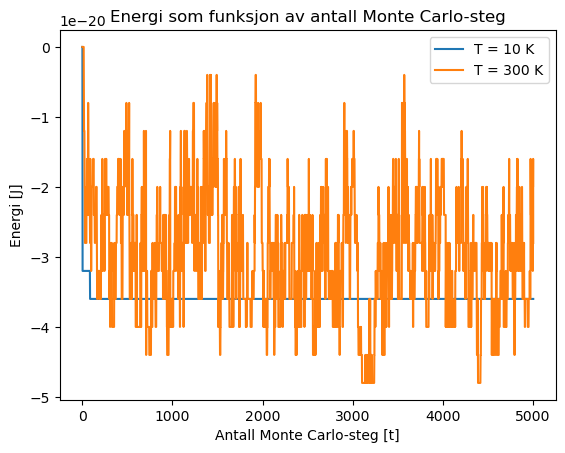

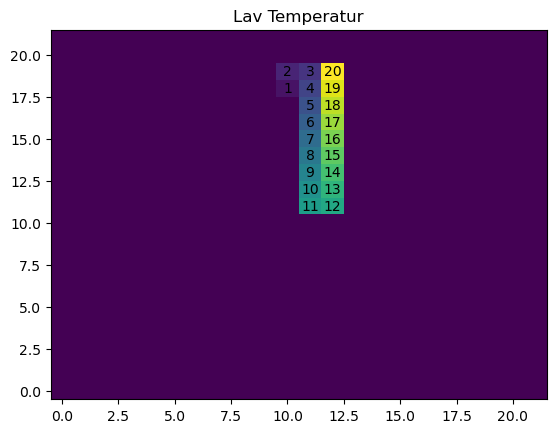

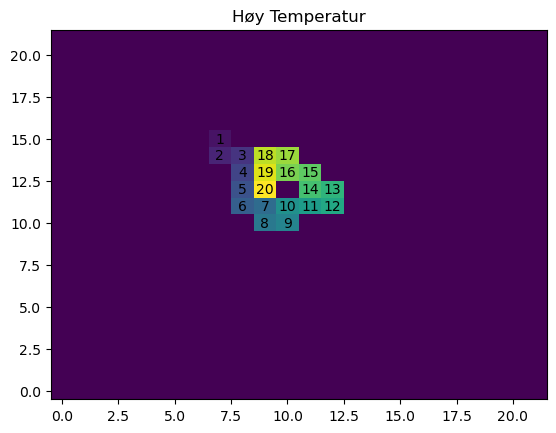

In [18]:
N = 20
polymer_start = makeStraightPolymer(N)
N_s = 5000
vekselvirkning = -4.0 * 10**(-21) #J
T_lav = 10 #K
T_hoy = 300 #K
V_matrise = make_V(polymer_start, vekselvirkning)

#Plotte energi energi som funksjon av antall Monte Carlo-steg
plt.xlabel('Antall Monte Carlo-steg [t]')
plt.ylabel('Energi [J]')
plt.title('Energi som funksjon av antall Monte Carlo-steg')

polymer_T_lav, energi_T_lav = metropolisalgoritmen(polymer_start, N_s, V_matrise, T_lav)
polymer_T_hoy, energi_T_hoy = metropolisalgoritmen(polymer_start, N_s, V_matrise, T_hoy)
 
t = np.arange(1, len(energi_T_lav)+1, 1)

plt.plot(t, energi_T_lav, label = f'T = {T_lav} K')
plt.plot(t, energi_T_hoy, label = f'T = {T_hoy} K')

plt.legend()
plt.show()

#Illustrere sluttpolymeren
illustratePolymer(polymer_T_lav, 'Lav Temperatur')
illustratePolymer(polymer_T_hoy, 'Høy Temperatur')

Tekst, svare på 2B) og 2), forklare figurene

Vi kan se at polymeren som har bøyd seg i høy temperatur er mindre viklet sammen siden flere
sannsynligheten for at polymeren roterer selv om energien blir høyere er større enn for
en polymer som roterer i lavere temperatur. Utdyp senere

Som vi nevnte tidligere i trenger ikke alle elementene i V-matrisen som ikke er null å være like, men den må være symetrisk. Vi skal nå se på et tilfelle der vekselvirkningen mellom monomer 2 og 5, og mellom 7 og 10, er dobbelt så stor som mellom de andre monomerene. Vekselvirkningen mellom de resterende beholder vi lik som i forrige oppgave og ser på et polymer med 20 monomerer. Ser på en lav temperatur slik at polymeren skal legge seg i et lokalt energiminimum.

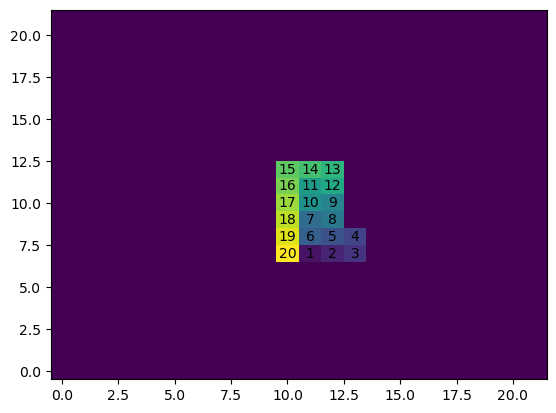

In [20]:
N = 20
T = 50
N_s = 8000
vekselvirkning = -4.0 * 10**(-21) #J
V_different = make_V(polymer_start, vekselvirkning)

#Endrer noen elementer i V
k = vekselvirkning * 2
V_different[2+1][5+1], V_different[5+1][2+1], V_different[7+1][10+1], V_different[10+1][7+1] = k, k, k, k

#Utfører simulering
polymer_vElementUnlike = metropolisalgoritmen(makeStraightPolymer(20), N_s, V_different, T)[0]

#Plotter sluttposisjon til polymeren
illustratePolymer(polymer_vElementUnlike, name ='') 

I dette tilfellet vil de lokale energiminimumene med lavest energi vil være de der monomer 2 og 5 ligger ved siden av hverandre og monomer 7 og 10 ligger ved siden av hverandre. I sluttpolymeret i denne simulasjonen, illustrert i figuren over, ser vi at nettopp dette er tilfellet. Dette gir fysisk mening fordi polymeren har har havnet i et lokalt energiminimum den ikke kommer seg ut av ved denne temperaturen.

Ser nå på forventningsverdien til energien som en funksjon temperaturen på intervallet [10, 1000]. 

In [ ]:
def forventningsVal_E(polymer, N_s, V, T_arr):
    forventningsverdi = np.zeros(len(T_arr))
    standardavvik = np.zeros(len(T_arr))
    
    for i in range(len(T_arr)):
        E_ar = metropolisalgoritmen(polymer, N_s, V, T_arr[i])[1]
        E_ar = E_ar[1000:]
        forventningsverdi[i] = np.average(E_ar)
        standardavvik[i] = np.sqrt(np.average(E_ar**2) - (np.average(E_ar))**2) #raskere m. np.average

    return forventningsverdi, standardavvik



## Konklusjon

Vi har nå sett på hvordan man kan simulere en polymerfolding i to dimensjoner og hvordan temperaturen i omgivelsene er med på å påvirke energien til polymeren og da også hvordan den blir seende ut. En polymer som formes i høy tempratur roterte vekk fra seg selv og strakk seg ut, mens en polymer i lavere temperatur krøllet seg mer sammen. Vi så også på forskjellen mellom å forme en polymer i økende og avtakende temperatur. Fra resultatene våre i (2g og 2h) så vi at .... 